## **PROJECT - NOTEBOOK #3: API - USAJOBS**

---

### **Setting Environment**

In [1]:
import os 
print(os.getcwd())

try:
    os.chdir("../../project_etl")

except FileNotFoundError:
    print("""
        FileNotFoundError - The directory may not exist or you might not be in the specified path.
        If this has already worked, do not run this block again, as the current directory is already set to project_etl.
        """)
    
print(os.getcwd())

d:\U\FIFTH SEMESTER\ETL\project_etl\notebooks
d:\U\FIFTH SEMESTER\ETL\project_etl


### **Importing modules and libraries**

In [2]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

### **API Connection**

In [3]:
API_KEY = "M5yC0zhQRl+OPdavWX7qKNpgpMILvk1ZxKqTMXpUgxU="
EMAIL = "sebasbelmosdev@gmail.com"  
BASE_URL = "https://data.usajobs.gov/api/search"
HEADERS = {
    "Host": "data.usajobs.gov",
    "User-Agent": EMAIL,
    "Authorization-Key": API_KEY
}

### **API Data Extraction**

In [4]:
def fetch_usajobs_data(query_params=None, max_pages=20, page_size=500):
    all_data = []
    page_number = 1
    
    session = requests.Session()
    retries = Retry(total=3, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
    session.mount("https://", HTTPAdapter(max_retries=retries))

    while page_number <= max_pages:
        params = {
            "Page": page_number,
            "ResultsPerPage": page_size,
            **(query_params or {})
        }
        try:
            if page_number == 1:
                time.sleep(5)
            
            response = session.get(BASE_URL, headers=HEADERS, params=params, timeout=10)
            response.raise_for_status()
            
            print(f"Response Status Code: {response.status_code}")
            print(f"Response Headers: {response.headers}")
            print(f"Raw Response Text: {response.text[:500]}...")
            
            data = response.json()
            search_results = data.get("SearchResult", {}).get("SearchResultItems", [])
            all_data.extend(search_results)
            
            total_count = data.get("SearchResult", {}).get("SearchResultCountAll", 0)
            print(f"Page {page_number}: Fetched {len(search_results)} items, Total Count: {total_count}")
            
            temp_df = pd.DataFrame(all_data)
            temp_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            temp_df.to_csv(f"data/temp/usajobs_temp_page_{page_number}_{temp_timestamp}.csv", index=False)
            print(f"Intermediate data saved to data/temp/usajobs_temp_page_{page_number}_{temp_timestamp}.csv")
            
            if len(search_results) == 0 or len(all_data) >= min(total_count, 10000):
                print(f"Stopping at page {page_number} with {len(all_data)} total entries.")
                break
                
            page_number += 1
            time.sleep(1)
        except requests.exceptions.RequestException as e:
            print(f"Error on page {page_number}: {e}")
            print(f"Response Text: {response.text if 'response' in locals() else 'No response'}")
            break
    
    return all_data

In [5]:
query_params = {
    #"Keyword": "tech",
    "LocationName": "United States"
}
job_data = fetch_usajobs_data(query_params)

Response Status Code: 200
Response Headers: {'Content-Type': 'application/hr+json; charset=utf-8', 'x-azure-ref': '20250520T184651Z-1859d697869sncnthC1BL19q3g0000000na000000000kpa3', 'Date': 'Tue, 20 May 2025 18:46:51 GMT', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive, Transfer-Encoding', 'Set-Cookie': 'akavpau_DATA_USAJ=1747767111~id=6b7a863b5fadc6aa0a637088c32f0860; Domain=data.usajobs.gov; Path=/; Secure; SameSite=None', 'Strict-Transport-Security': 'max-age=31536000 ; includeSubDomains'}
Raw Response Text: {"LanguageCode":"EN","SearchParameters":{},"SearchResult":{"SearchResultCount":500,"SearchResultCountAll":8141,"SearchResultItems":[{"MatchedObjectId":"547366900","MatchedObjectDescriptor":{"PositionID":"AGL-ERR-20-2101-63651","PositionTitle":"Technical Operations (AJW) Airway Transportation Systems Specialist Employee Requested Reassignment","PositionURI":"https://www.usajobs.gov:443/GetJob/ViewDetails/547366900","ApplyURI":["https://www.usajobs.gov:443/GetJob/ViewD

In [6]:
def inspect_api_structure(job_data):
    all_keys = set()
    for item in job_data[:5]: 
        def extract_keys(obj, parent_key=""):
            if isinstance(obj, dict):
                for key, value in obj.items():
                    new_key = f"{parent_key}.{key}" if parent_key else key
                    all_keys.add(new_key)
                    extract_keys(value, new_key)
            elif isinstance(obj, list):
                for i, value in enumerate(obj):
                    extract_keys(value, f"{parent_key}[{i}]")
        
        extract_keys(item)
    return sorted(all_keys)

In [7]:
print("Available keys and nested paths in the API response:")
print(inspect_api_structure(job_data))

print("\nSample API response (first item):")
print(json.dumps(job_data[0], indent=2) if job_data else "No data available")

Available keys and nested paths in the API response:
['MatchedObjectDescriptor', 'MatchedObjectDescriptor.ApplicationCloseDate', 'MatchedObjectDescriptor.ApplyURI', 'MatchedObjectDescriptor.DepartmentName', 'MatchedObjectDescriptor.JobCategory', 'MatchedObjectDescriptor.JobCategory[0].Code', 'MatchedObjectDescriptor.JobCategory[0].Name', 'MatchedObjectDescriptor.JobGrade', 'MatchedObjectDescriptor.JobGrade[0].Code', 'MatchedObjectDescriptor.OrganizationName', 'MatchedObjectDescriptor.PositionEndDate', 'MatchedObjectDescriptor.PositionFormattedDescription', 'MatchedObjectDescriptor.PositionFormattedDescription[0].Label', 'MatchedObjectDescriptor.PositionFormattedDescription[0].LabelDescription', 'MatchedObjectDescriptor.PositionID', 'MatchedObjectDescriptor.PositionLocation', 'MatchedObjectDescriptor.PositionLocationDisplay', 'MatchedObjectDescriptor.PositionLocation[0].CityName', 'MatchedObjectDescriptor.PositionLocation[0].CountryCode', 'MatchedObjectDescriptor.PositionLocation[0].Cou

In [8]:
df = pd.DataFrame([{
    "PositionID": item["MatchedObjectDescriptor"]["PositionID"],
    "PositionTitle": item["MatchedObjectDescriptor"]["PositionTitle"],
    "PositionURI": item["MatchedObjectDescriptor"]["PositionURI"],
    "Location": item["MatchedObjectDescriptor"].get("PositionLocationDisplay", "Unknown"),
    "City": next((loc.get("CityName", "Unknown") for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), "Unknown"),
    "State": next((loc.get("CountrySubDivisionCode", "Unknown") for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), "Unknown"),
    "Country": next((loc.get("CountryCode", "Unknown") for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), "Unknown"),
    "Latitude": next((loc.get("Latitude", None) for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), None),
    "Longitude": next((loc.get("Longitude", None) for loc in item["MatchedObjectDescriptor"].get("PositionLocation", [])), None),
    "Organization": item["MatchedObjectDescriptor"].get("OrganizationName", "Unknown"),
    "Department": item["MatchedObjectDescriptor"].get("DepartmentName", "Unknown"),
    "MinSalary": next((float(rem.get("MinimumRange", 0)) for rem in item["MatchedObjectDescriptor"].get("PositionRemuneration", [])), 0),
    "MaxSalary": next((float(rem.get("MaximumRange", 0)) for rem in item["MatchedObjectDescriptor"].get("PositionRemuneration", [])), 0),
    "SalaryInterval": next((rem.get("RateIntervalCode", "Unknown") for rem in item["MatchedObjectDescriptor"].get("PositionRemuneration", [])), "Unknown"),
    "JobCategory": next((cat.get("Name", "Unknown") for cat in item["MatchedObjectDescriptor"].get("JobCategory", [])), "Unknown"),
    "JobGrade": next((grade.get("Code", "Unknown") for grade in item["MatchedObjectDescriptor"].get("JobGrade", [])), "Unknown"),
    "Schedule": next((sched.get("Name", "Unknown") for sched in item["MatchedObjectDescriptor"].get("PositionSchedule", [])), "Unknown"),
    "OfferingType": next((offer.get("Name", "Unknown") for offer in item["MatchedObjectDescriptor"].get("PositionOfferingType", [])), "Unknown"),
    "StartDate": item["MatchedObjectDescriptor"].get("PositionStartDate", None),
    "EndDate": item["MatchedObjectDescriptor"].get("PositionEndDate", None),
    "PublicationDate": item["MatchedObjectDescriptor"].get("PublicationStartDate", None),
    "CloseDate": item["MatchedObjectDescriptor"].get("ApplicationCloseDate", None),
    "TeleworkEligible": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("TeleworkEligible", False),
    "SecurityClearance": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("SecurityClearance", "Unknown"),
    "PromotionPotential": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("PromotionPotential", "Unknown"),
    "TravelCode": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("TravelCode", "Unknown"),
    "HiringPath": next((path for path in item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("HiringPath", [])), "Unknown"),
    "TotalOpenings": item["MatchedObjectDescriptor"].get("UserArea", {}).get("Details", {}).get("TotalOpenings", "Unknown")
} for item in job_data])

### **Data Cleansing**

In [9]:
df.head()

,PositionID,PositionTitle,PositionURI,Location,City,State,Country,Latitude,Longitude,Organization,...,StartDate,EndDate,PublicationDate,CloseDate,TeleworkEligible,SecurityClearance,PromotionPotential,TravelCode,HiringPath,TotalOpenings
0,AGL-ERR-20-2101-63651,Technical Operations (AJW) Airway Transportati...,https://www.usajobs.gov:443/GetJob/ViewDetails...,FAA Tech Ops 2101 ERR Duty Locations Throughou...,"Saint Croix, Virgin Islands",Virgin Islands,United States,17.736315,-64.73595,Federal Aviation Administration,...,2024-08-18T00:00:00.0000,2025-08-17T23:59:59.9970,2024-08-18T00:00:00.0000,2025-08-17T23:59:59.9970,False,Other,NA,2,fed-internal-search,Many
1,DE-11553179-22-MVP,BOILER PLANT EQUIPMENT MECHANIC,https://www.usajobs.gov:443/GetJob/ViewDetails...,Multiple Locations,"China Lake, California",California,United States,35.650600,-117.67000,Naval Facilities Engineering Systems Command,...,2024-07-09T00:00:00.0000,2025-07-08T23:59:59.9970,2024-07-09T00:00:00.0000,2025-07-08T23:59:59.9970,False,Secret,10,0,public,1
2,DE-11599009-22-PLD,AIR CONDITIONING EQUIPMENT MECHANIC,https://www.usajobs.gov:443/GetJob/ViewDetails...,Multiple Locations,"China Lake, California",California,United States,35.650600,-117.67000,Naval Facilities Engineering Systems Command,...,2024-07-16T00:00:00.0000,2025-07-15T23:59:59.9970,2024-07-16T00:00:00.0000,2025-07-15T23:59:59.9970,False,Secret,None,0,public,FEW
3,DE-11611689-22-CCR,ELECTRICIAN,https://www.usajobs.gov:443/GetJob/ViewDetails...,Multiple Locations,"China Lake, California",California,United States,35.650600,-117.67000,Naval Facilities Engineering Systems Command,...,2024-07-09T00:00:00.0000,2025-07-08T23:59:59.9970,2024-07-09T00:00:00.0000,2025-07-08T23:59:59.9970,False,Secret,None,0,public,1
4,DE-11612048-22-DDF,PLUMBER,https://www.usajobs.gov:443/GetJob/ViewDetails...,Multiple Locations,"China Lake, California",California,United States,35.650600,-117.67000,Naval Facilities Engineering Systems Command,...,2024-07-09T00:00:00.0000,2025-07-08T23:59:59.9970,2024-07-09T00:00:00.0000,2025-07-08T23:59:59.9970,False,Secret,9,0,public,Unknown


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PositionID          8143 non-null   object 
 1   PositionTitle       8143 non-null   object 
 2   PositionURI         8143 non-null   object 
 3   Location            8143 non-null   object 
 4   City                8143 non-null   object 
 5   State               8143 non-null   object 
 6   Country             8143 non-null   object 
 7   Latitude            8143 non-null   float64
 8   Longitude           8143 non-null   float64
 9   Organization        8143 non-null   object 
 10  Department          8143 non-null   object 
 11  MinSalary           8143 non-null   float64
 12  MaxSalary           8143 non-null   float64
 13  SalaryInterval      8143 non-null   object 
 14  JobCategory         8143 non-null   object 
 15  JobGrade            8143 non-null   object 
 16  Schedu

#### **Handle missing values**

In [11]:
df = df.fillna({
    "MinSalary": 0,
    "MaxSalary": 0,
    "City": "Unknown",
    "State": "Unknown",
    "Country": "Unknown",
    "Latitude": 0,
    "Longitude": 0
})

#### **Convert salary to numeric and filter out invalid values**

In [12]:
df["MinSalary"] = pd.to_numeric(df["MinSalary"], errors="coerce").fillna(0)
df["MaxSalary"] = pd.to_numeric(df["MaxSalary"], errors="coerce").fillna(0)
print("Before filtering:", len(df))
df = df[(df["MinSalary"] > 0) & (df["MaxSalary"] > 0)]
print("After filtering:", len(df))

Before filtering: 8143
After filtering: 8126


#### **Normalise salary to yearly**

In [13]:
df["NormalisedSalary"] = df.apply(
    lambda x: x["MinSalary"] if x["SalaryInterval"] == "PA" 
    else x["MinSalary"] * 2080 if x["SalaryInterval"] == "PH" 
    else x["MinSalary"] * 12 if x["SalaryInterval"] == "PM" 
    else x["MinSalary"], axis=1
)

#### **Convert dates to datetime**

In [14]:
date_columns = ["StartDate", "EndDate", "PublicationDate", "CloseDate"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors="coerce")

#### **Save to CSV**

In [15]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file = f"data/api/usajobs_data_{timestamp}.csv"
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

OSError: Cannot save file into a non-existent directory: 'data\api'

### **Exploratory Data Analysis (EDA)**

In [16]:
df.describe()

,Latitude,Longitude,MinSalary,MaxSalary,StartDate,EndDate,PublicationDate,CloseDate,NormalisedSalary
count,8122.000000,8122.000000,8122.000000,8122.000000,8122,8122,8122,8122,8122.000000
mean,38.131341,-95.256849,72707.794883,106440.414138,2025-03-25 02:43:20.653100032,2025-07-19 15:18:02.390499584,2025-03-25 02:43:20.653100032,2025-07-19 15:18:02.390499584,86595.520002
min,-14.314673,-176.657500,1.000000,15.000000,2024-05-24 00:00:00,2025-05-20 23:59:59.997000,2024-05-24 00:00:00,2025-05-20 23:59:59.997000,1.000000
25%,34.048300,-111.888230,32.590000,41.457500,2025-02-21 00:00:00,2025-05-27 23:59:59.996999936,2025-02-21 00:00:00,2025-05-27 23:59:59.996999936,45000.000000
50%,38.755983,-92.222470,59770.000000,86873.000000,2025-05-01 16:05:50.020000,2025-06-03 23:59:59.996999936,2025-05-01 16:05:50.020000,2025-06-03 23:59:59.996999936,63862.000000
75%,41.589787,-78.896010,95556.000000,148073.000000,2025-05-14 10:53:09.872499968,2025-08-18 23:59:59.996999936,2025-05-14 10:53:09.872499968,2025-08-18 23:59:59.996999936,96667.000000
max,71.289970,145.764100,400000.000000,400000.000000,2025-05-20 14:26:21.523000,2026-05-20 23:59:59.997000,2025-05-20 14:26:21.523000,2026-05-20 23:59:59.997000,400000.000000
std,7.430311,26.082679,77265.895624,105304.787845,NaN,NaN,NaN,NaN,67108.760434


#### **Salary Distribution**

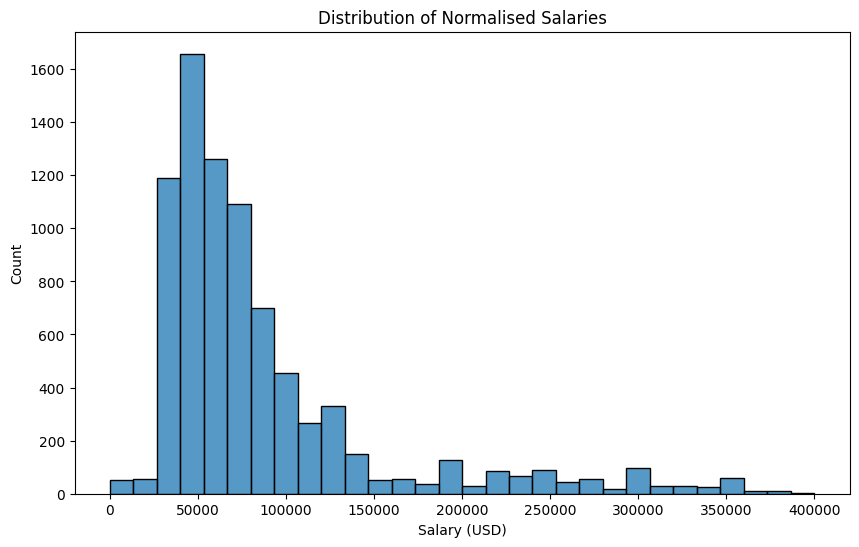

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="NormalisedSalary", bins=30)
plt.title("Distribution of Normalised Salaries")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.show()

#### **Job Postings by Organization**

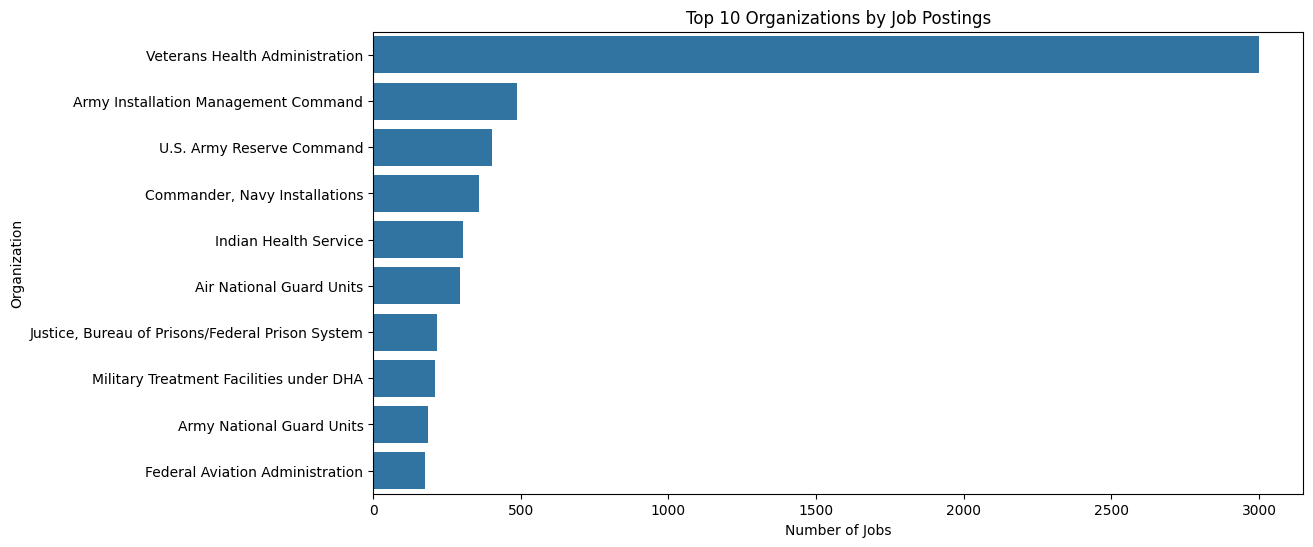

In [18]:
plt.figure(figsize=(12, 6))
top_orgs = df["Organization"].value_counts().head(10)
sns.barplot(x=top_orgs.values, y=top_orgs.index)
plt.title("Top 10 Organizations by Job Postings")
plt.xlabel("Number of Jobs")
plt.ylabel("Organization")
plt.show()

#### **Job Postings Over Time**

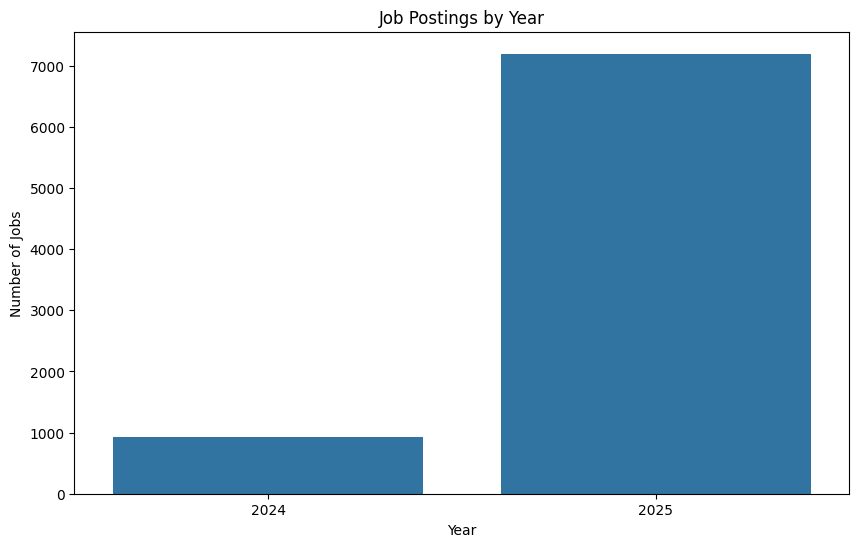

In [19]:
df["PublicationYear"] = df["PublicationDate"].dt.year
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="PublicationYear")
plt.title("Job Postings by Year")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.show()

#### **Remote Work Eligibility**

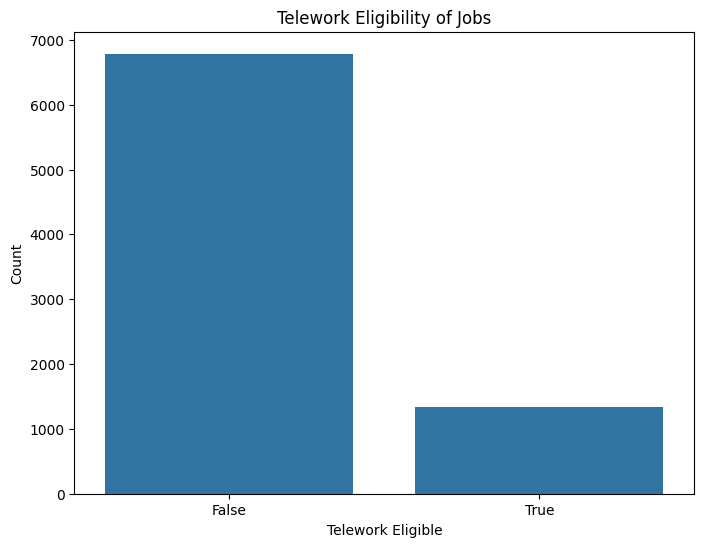

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="TeleworkEligible")
plt.title("Telework Eligibility of Jobs")
plt.xlabel("Telework Eligible")
plt.ylabel("Count")
plt.show()

#### **Hiring Path Distribution**

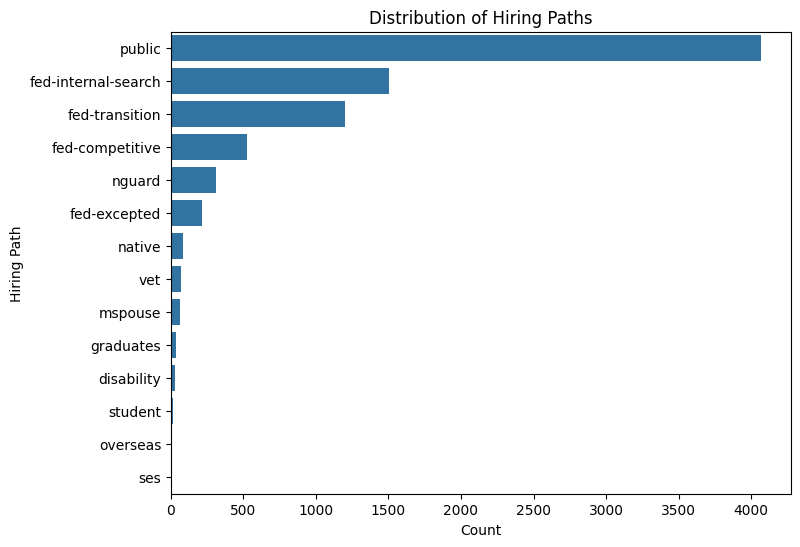

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, y="HiringPath", order=df["HiringPath"].value_counts().index) 
plt.title("Distribution of Hiring Paths")
plt.xlabel("Count") 
plt.ylabel("Hiring Path")
plt.show()